**À lire:** 
1. Optimal Schedule for Networked Microgrids under Deregulated Power Market Environment using Model Predictive Control
1. Model predictive control of microgrids – An overview

**Lib python:** https://www.do-mpc.com/en/latest/getting_started.html


In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib as mpl
import scipy 
import do_mpc
from casadi import * 

### First define model 

In [2]:
model_type= 'continuous'
model = do_mpc.model.Model(model_type)

### Define model variables (state, for instance) 

In [3]:
phi_1 = model.set_variable(var_type = '_x', var_name = 'phi_1', shape = (1,1))
phi_2 = model.set_variable(var_type = '_x', var_name = 'phi_2', shape = (1,1))
phi_3 = model.set_variable(var_type = '_x', var_name = 'phi_3', shape = (1,1))

dphi = model.set_variable(var_type = '_x', var_name = 'dphi', shape = (3,1))
# Desired motor position
phi_m_1_set = model.set_variable(var_type = '_u', var_name = 'phi_m_1_set')
phi_m_2_set = model.set_variable(var_type = '_u', var_name = 'phi_m_2_set')
# true motor position
phi_1_m = model.set_variable(var_type = '_x', var_name = 'phi_1_m', shape = (1,1))
phi_2_m = model.set_variable(var_type = '_x', var_name = 'phi_2_m', shape = (1,1))

###  Parameters

In [4]:
theta_1 = model.set_variable('parameter', 'theta_1')
theta_2 = model.set_variable('parameter', 'theta_2')
theta_3 = model.set_variable('parameter', 'theta_3')

c = np.array([2.697,  2.66,  3.05, 2.86])*1e-3
d = np.array([6.78,  8.01,  8.82])*1e-5

### Right-hand side

In [5]:
model.set_rhs('phi_1', dphi[0])
model.set_rhs('phi_2', dphi[1])
model.set_rhs('phi_3', dphi[2])

dphi_next = vertcat(-c[0]/theta_1 * (phi_1 - phi_1_m) - c[1]/theta_1 * (phi_1 - phi_2) - d[0]/theta_1 * dphi[0], 
                    -c[1]/theta_2 * (phi_2 - phi_1) - c[2]/theta_2 * (phi_2 - phi_3) - d[1]/theta_2 * dphi[1],
                    -c[2]/theta_3 * (phi_3 - phi_2) - c[3]/theta_3 * (phi_3 - phi_2_m) - d[2]/theta_3 * dphi[2]
                   )
model.set_rhs('dphi', dphi_next)

In [6]:
tau = 1e-2
model.set_rhs('phi_1_m', 1/tau * (phi_m_1_set - phi_1_m))
model.set_rhs('phi_2_m', 1/tau * (phi_m_2_set - phi_2_m))

In [7]:
model.setup()

In [8]:
mpc = do_mpc.controller.MPC(model)

In [9]:
setup_mpc = {
    'n_horizon': 20, 
    't_step': 0.1, 
    'n_robust': 1,
    'store_full_solution': True
}
mpc.set_param(**setup_mpc)

In [10]:
mterm = phi_1**2 + phi_2**2 + phi_3**2
lterm = phi_1**2 + phi_2**2 + phi_3**2
mpc.set_objective(mterm = mterm, lterm = lterm)

In [11]:
mpc.set_rterm(phi_m_1_set = 1e-2, 
              phi_m_2_set = 1e-2)

### Constraints

In [12]:
# Lower bounds on states:
mpc.bounds['lower','_x', 'phi_1'] = -2*np.pi
mpc.bounds['lower','_x', 'phi_2'] = -2*np.pi
mpc.bounds['lower','_x', 'phi_3'] = -2*np.pi
# Upper bounds on states
mpc.bounds['upper','_x', 'phi_1'] = 2*np.pi
mpc.bounds['upper','_x', 'phi_2'] = 2*np.pi
mpc.bounds['upper','_x', 'phi_3'] = 2*np.pi

# Lower bounds on inputs:
mpc.bounds['lower','_u', 'phi_m_1_set'] = -2*np.pi
mpc.bounds['lower','_u', 'phi_m_2_set'] = -2*np.pi
# Lower bounds on inputs:
mpc.bounds['upper','_u', 'phi_m_1_set'] = 2*np.pi
mpc.bounds['upper','_u', 'phi_m_2_set'] = 2*np.pi

### Uncertainty 

In [13]:
inertia_mass_1 = 2.25*1e-4*np.array([1., 0.9, 1.1])
inertia_mass_2 = 2.25*1e-4*np.array([1., 0.9, 1.1])
inertia_mass_3 = 2.25*1e-4*np.array([1.])

mpc.set_uncertainty_values(
    theta_1 = inertia_mass_1,
    theta_2 = inertia_mass_2,
    theta_3 = inertia_mass_3
)

In [14]:
mpc.setup()

### Simulator

In [15]:
simulator= do_mpc.simulator.Simulator(model)
simulator.set_param(t_step = 0.1)

In [16]:
p_template = simulator.get_p_template()
p_template.keys()

['default', 'theta_1', 'theta_2', 'theta_3']

In [17]:
def p_fun(t_now):
    p_template['theta_1'] = 2.25e-4
    p_template['theta_2'] = 2.25e-4
    p_template['theta_3'] = 2.25e-4
    return p_template

In [18]:
simulator.set_p_fun(p_fun)

In [19]:
simulator.setup()

In [20]:
x0 = np.pi*np.array([1, 1, -1.5, 1, -1, 1, 0, 0]).reshape(-1,1)
simulator.x0 = x0 
mpc.x0 = x0

In [21]:
mpc.set_initial_guess()

### Viz

In [22]:
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True

In [23]:
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
sim_graphics = do_mpc.graphics.Graphics(simulator.data)

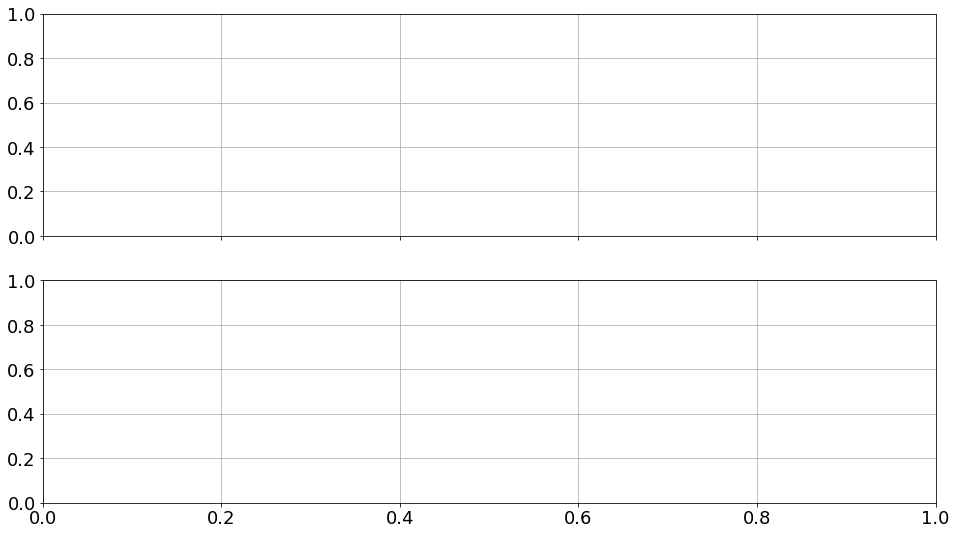

In [24]:
fig, ax = plt.subplots(2, sharex=True, figsize=(16,9))
fig.align_ylabels()

In [31]:
for i in range(10):
    u0 = mpc.make_step(x0)
    x0 = simulator.make_step(u0)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    19448
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1229

Total number of variables............................:     6408
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     2439
                     variables with only upper bounds:        0
Total number of equality constraints.................:     5768
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Total number of variables............................:     6408
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     2439
                     variables with only upper bounds:        0
Total number of equality constraints.................:     5768
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.2780180e-35 3.80e-18 1.93e-33  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  9.4628526e-36 3.35e-31 6.94e-18  -1.0 4.42e-18  -4.0 1.00e+00 1.00e+00   0
   2  9.4692479e-36 1.02e-32 4.34e-19  -2.5 6.93e-20  -4.5 1.00e+00 1.00e+00T  0
   3  1.0359794e-35 7.01e-32 2.71e-20  -3.8 2.21e-18  -5.0 1.00e+00 1.00e+00T  0
   4  9.3528214e-3

                     variables with only lower bounds:        0
                variables with lower and upper bounds:     2439
                     variables with only upper bounds:        0
Total number of equality constraints.................:     5768
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.5173900e-36 2.24e-18 6.26e-34  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  3.0467891e-36 2.50e-31 3.47e-18  -1.0 2.24e-18  -4.0 1.00e+00 1.00e+00   0
   2  3.0712999e-36 5.01e-32 1.03e-18  -2.5 4.82e-20  -4.5 1.00e+00 1.00e+00T  0
   3  3.6659189e-36 3.05e-31 2.71e-20  -3.8 1.93e-18  -5.0 1.00e+00 1.00e+00T  0
   4  2.9269993e-36 1.64e-31 1.69e-21  -5.7 1.72e-18  -5.4 1.00e+00 1.00e+00T  0
 

Total number of variables............................:     6408
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     2439
                     variables with only upper bounds:        0
Total number of equality constraints.................:     5768
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.1591535e-36 7.81e-19 3.85e-34  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  8.4237165e-37 4.92e-31 3.47e-18  -1.0 1.26e-18  -4.0 1.00e+00 1.00e+00   0
   2  8.4298291e-37 2.86e-32 3.25e-19  -2.5 3.59e-20  -4.5 1.00e+00 1.00e+00T  0
   3  1.3458434e-36 1.99e-31 2.71e-20  -3.8 1.53e-18  -5.0 1.00e+00 1.00e+00T  0
   4  8.3377527e-3

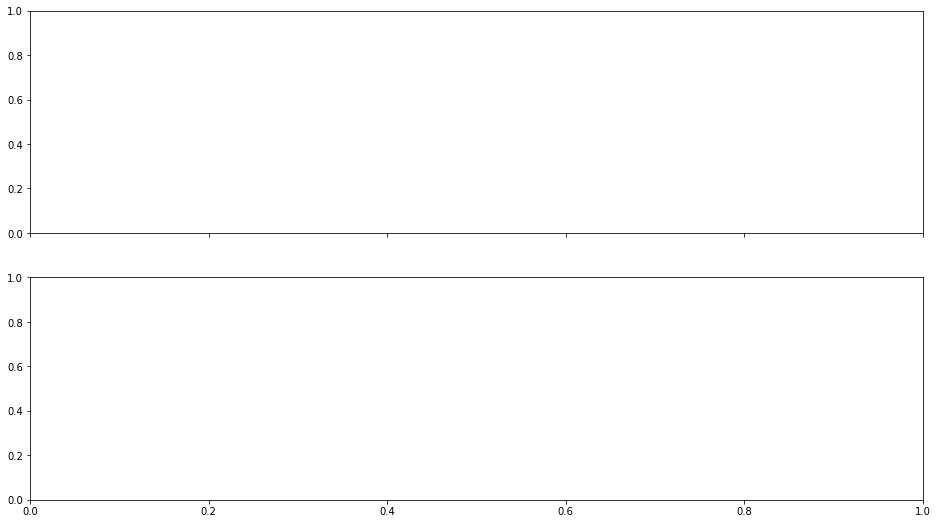

In [76]:
mpc_graphics.plot_predictions()
mpc_graphics.reset_axes()
fig